# Predict response to stimuli: lstm for time series

In a *lstm timeseries* problem, we aim to predict the response of a stimuli, as a time series data. The input is a stimuli vs time and the output is response vs time curve. Depending on how we train the network the response curve could represent average response to the stimuli from different spatial locations or could represet response form a single spatial location. 

This notebook builds an LSTM based model to predict the response to external stimuli. To do this, we'll provide the model with timeseries of stimuli and use the return sequences to return an output vector that has the same shape as that of the input time series, the output represents response to the stimuli.

In [12]:
import keras, tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imageio import imread
from IPython import display
from pathlib import Path
import os

The input csv file contains N columns of response as tabular data, we load the data from disk and read it to a numpy array

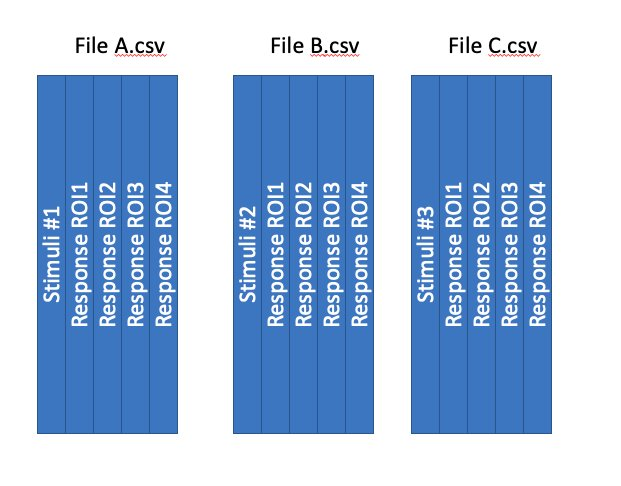

In [13]:
display.Image(filename='../images/data_style.jpg')

In [14]:
data_dir = Path('C:/Users/rando/Downloads/stimuli_response/')
files = list(data_dir.glob('*.csv'))
stimuli = []
response_roi = []
response = {}
model_name = []
common_name = 'ROI'
for count, file in enumerate(files):
    
  stimuli_data = pd.read_csv(file)
  
  stimuli_data_tuple = stimuli_data.to_numpy()
  stimuli_data_array = np.asarray(stimuli_data_tuple)
  stimuli.append(stimuli_data_array[:,0])
  for i in range(stimuli_data_array.shape[1]):
    if common_name + str(i) in response.keys():
      response_list = response[common_name + str(i)]
      response_list.append(stimuli_data_array[:,i]) 
    else:  
      response[common_name + str(i)] = [stimuli_data_array[:,i]]
  
stimuli = np.asarray(stimuli)
#This is our input data for training
stimuli = np.reshape(stimuli, (count + 1, stimuli_data_array.shape[0], 1 ) )
# Now we create a dictionary of the target whose key is the name of the model and value is the training label
for (k,v) in response.items():
    varr = np.asarray(v)
    response[k] = varr
    print('Model Name', k, 'Output data shape', varr.shape)
print('Input data shape', stimuli.shape)    

Model Name ROI0 Output data shape (9, 1999)
Model Name ROI1 Output data shape (9, 1999)
Model Name ROI2 Output data shape (9, 1999)
Model Name ROI3 Output data shape (9, 1999)
Model Name ROI4 Output data shape (9, 1999)
Model Name ROI5 Output data shape (9, 1999)
Model Name ROI6 Output data shape (9, 1999)
Model Name ROI7 Output data shape (9, 1999)
Model Name ROI8 Output data shape (9, 1999)
Model Name ROI9 Output data shape (9, 1999)
Model Name ROI10 Output data shape (9, 1999)
Input data shape (9, 1999, 1)


In [15]:
input_shape = (stimuli.shape[1],stimuli.shape[2])
lstm_units = 128
learning_rate = 0.01
epochs = 150
batch_size = 4
validation_split = 0.1

The dataset contains 4 colums of the stimuli and the first number represents the number of timepoints present in the data

In [16]:
from keras import layers, models
from keras.layers import ConvLSTM1D, LSTM, Conv1D, Dense, Bidirectional
img_input = layers.Input(shape = input_shape)
x = (LSTM(lstm_units, return_sequences=True))(img_input)

x = Dense(lstm_units, activation= 'linear')(x)
x = Dense(1, activation= 'linear')(x)
outputs = x
model = models.Model(img_input, outputs)
opt = keras.optimizers.RMSprop(lr=learning_rate)

model.compile(loss='mse',
              optimizer=opt, metrics = ['mae'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1999, 1)]         0         
                                                                 
 lstm_1 (LSTM)               (None, 1999, 128)         66560     
                                                                 
 dense_2 (Dense)             (None, 1999, 128)         16512     
                                                                 
 dense_3 (Dense)             (None, 1999, 1)           129       
                                                                 
Total params: 83,201
Trainable params: 83,201
Non-trainable params: 0
_________________________________________________________________


c:\Users\rando\anaconda3\envs\naparienv\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Now let us plot the network graph using keras plot_model

<IPython.core.display.Image object>


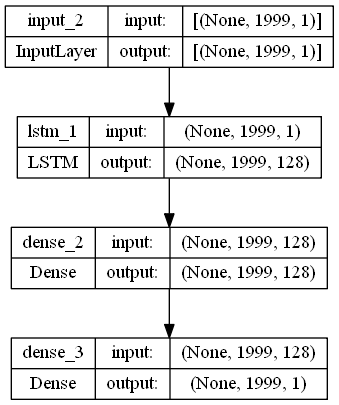

In [17]:
from keras.utils import plot_model

model_inline = plot_model(model, to_file = './model_time_series.png', 
show_shapes = True, show_layer_names=True)

print(model_inline)
model_inline

In [18]:
def plot_history(history):
  plt.figure()
  plt.plot(history.epoch, np.array(history.history['mae']),
           label='Train Loss')
  plt.plot(history.epoch, np.array(history.history['val_mae']),
           label = 'Val loss')
  plt.legend()
  plt.ylim([0, 5])

Now let us start the model training by first defining some parameters like epochs, validation_split, keras callbacks etc

In [21]:
for (k,v) in response.items():
        model_name = k 
        history = model.fit(stimuli, v,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose = True,
                    validation_split= validation_split,
                    shuffle=True)
        plot_history(history) 
        model.save(os.path.join(data_dir.as_posix() + model_name + '.h5'))

Epoch 1/150
2/2 [==============================] - 1s 279ms/step - loss: 0.0041 - mae: 0.0566 - val_loss: 0.0064 - val_mae: 0.0767
Epoch 2/150
2/2 [==============================] - 0s 192ms/step - loss: 0.0112 - mae: 0.0942 - val_loss: 0.0094 - val_mae: 0.0946
Epoch 3/150
2/2 [==============================] - 0s 164ms/step - loss: 0.0141 - mae: 0.1054 - val_loss: 0.0065 - val_mae: 0.0771
Epoch 4/150
2/2 [==============================] - 0s 251ms/step - loss: 0.0082 - mae: 0.0807 - val_loss: 0.0041 - val_mae: 0.0620
Epoch 5/150
2/2 [==============================] - 0s 165ms/step - loss: 0.0051 - mae: 0.0642 - val_loss: 0.0036 - val_mae: 0.0570
Epoch 6/150
2/2 [==============================] - 0s 175ms/step - loss: 0.0056 - mae: 0.0648 - val_loss: 0.0058 - val_mae: 0.0697
Epoch 7/150
2/2 [==============================] - 0s 168ms/step - loss: 0.0090 - mae: 0.0813 - val_loss: 0.0069 - val_mae: 0.0789
Epoch 8/150
1/2 [==============>...............] - ETA: 0s - loss: 0.0074 - mae: 0.